# Comparing Rust vs Python performance

## Rust - Custom Library 
- custom implementation of BytePairEncoding Tokenizer from scratch
- using PyO3 to generate Python bindings
- Generating Python Wheel and Installing

## Python
- Raw Python
- Andrej Karpathy's implementation of BytePairEncoding Tokenizer in pure Python (https://github.com/karpathy/minbpe/tree/master/minbpe)

In [1]:
# Inject pypath
import sys
import os
def inject_pyp():
    """Sets the Python Path to include the minbpe directory"""
    sys.path.append(os.path.abspath(os.path.join('minbpe')))

In [12]:
# Testers

from typing import Any

def print_enc_dec(lang: str, tokenizer: Any, text: str, verbose: bool = False) -> None:
    """
    Prints results to the terminal
    Will get a `lang` indetifier, a tokenizer object and text 
    """
    ids = tokenizer.encode(text, verbose = verbose)
    # print(f"[{lang}] Tokens IDs:".ljust(10), ids)

    # Decoding text
    decoded_text = tokenizer.decode(ids)
    # print(f"[  {lang}  ] Decoded tokens:".ljust(10), decoded_text)
    
    return ids, decoded_text

In [4]:
# TESTING RAW ENCODE/DECODE

import sys
import os
sys.path.append(os.path.abspath(os.path.join('minbpe')))
from minbpe.bpe import BPETokenizer as PyBPETokenizer
from rust_llm import BPETokenizer as RustBPETokenizer
import time

print("Testing BPE Tokenizer")
source_text = "We've just built a RUST library for Python!"

print("--"*10 + "Python" + "--"*10)
st = time.time_ns()
pytok = PyBPETokenizer()
print_enc_dec("Python".rjust(6), pytok, source_text)
en = time.time_ns() - st
print(f"Python BPE took {en} ns")

print("--"*10 + "RUST" + "--"*10)
st = time.time_ns()
rutok = RustBPETokenizer()
print_enc_dec("RUST", rutok, source_text)
en = time.time_ns() - st
print(f"Rust BPE took {en} ns")


Testing BPE Tokenizer
--------------------Python--------------------
[Python] Tokens IDs: [87, 101, 39, 118, 101, 32, 106, 117, 115, 116, 32, 98, 117, 105, 108, 116, 32, 97, 32, 82, 85, 83, 84, 32, 108, 105, 98, 114, 97, 114, 121, 32, 102, 111, 114, 32, 80, 121, 116, 104, 111, 110, 33]
[  Python  ] Decoded tokens: We've just built a RUST library for Python!
Python BPE took 147000 ns
--------------------RUST--------------------
[RUST] Tokens IDs: [87, 101, 39, 118, 101, 32, 106, 117, 115, 116, 32, 98, 117, 105, 108, 116, 32, 97, 32, 82, 85, 83, 84, 32, 108, 105, 98, 114, 97, 114, 121, 32, 102, 111, 114, 32, 80, 121, 116, 104, 111, 110, 33]
[  RUST  ] Decoded tokens: We've just built a RUST library for Python!
Rust BPE took 432000 ns


In [4]:
"""
Let's train the tokenizer in Rust and then use it from Python.
"""
inject_pyp()
import time
from rust_llm import BPETokenizer as RuBPETokenizer
from minbpe.bpe import BPETokenizer as PyBPETokenizer
from typing import Any

def train(tokenizer: Any, text: str, vocab_size: int, lang: str):
    t0 = time.time_ns()
    tokenizer.train(text, vocab_size, verbose=False)
    dur = (time.time_ns() - t0) / 1e9
    print(f"[{lang}] Trained vocab size:".ljust(10), vocab_size)
    print(f"[{lang}] Time: {dur} sec")
    tokenizer.save_model(f"{lang}_model")
    print(f"[{lang}] Saved:", f"{lang}_model")

# TRAINING TOKENIZERS
text = open("taylorswift.txt", "r", encoding="utf-8").read()

# Python
# pytok = PyBPETokenizer()
# train(pytok, text, 512, "Python")

# Rust
rutok = RuBPETokenizer()
train(rutok, text, 512, "RUST")




[RUST] Trained vocab size: 512
[RUST] Time: 16.657778 sec
[RUST] Saved: RUST_model


In [3]:
rutok.load_model("RUST_model.model")

In [ ]:
# Testing Tokenizers
source_text = "We've just built a RUST library for Python!"
print("--"*10 + "Python" + "--"*10)
pytok = PyBPETokenizer()
pytok.load_model("Python_model.model")
print_enc_dec("Python".rjust(6), pytok, source_text, verbose=False)

print("--"*10 + "RUST" + "--"*10)
rutok = RuBPETokenizer()
rutok.load("RUST_model.model")
print_enc_dec("RUST", rutok, source_text, verbose=False)


In [16]:
import time
from minbpe.bpe import BPETokenizer as PyBPETokenizer
from rust_llm import BPETokenizer as RustBPETokenizer
source_text = open("taylorswift.txt", "r", encoding="utf-8").read()
model_name = "./rust.model"

pytok = PyBPETokenizer()
pytok.load_model(model_name)
def test_python_tokenizer(n: int):
    ttimes = []
    for _ in range(n):
        s = time.time_ns()
        ids = pytok.encode(source_text)
        text = pytok.decode(ids)
        ttimes.append(time.time_ns() - s)
    return ttimes

rutok = RustBPETokenizer()
rutok.load_model(model_name, verbose=False)
def test_rust_tokenizer(n: int):
    ttimes = []
    for _ in range(n):
        s = time.time_ns()
        ids = rutok.encode(source_text, verbose=False)
        text = rutok.decode(ids)
        ttimes.append(time.time_ns() - s)
    return ttimes

n = 100
ptime = test_python_tokenizer(n)
rtime = test_rust_tokenizer(n)
print(f"Python Tokenizer: {sum(ptime) / 1e9:.2f} seconds for {n} runs")
print(f"Rust Tokenizer: {sum(rtime) / 1e9:.2f} seconds for {n} runs")


Python Tokenizer: 18.94 seconds for 100 runs
Rust Tokenizer: 3.69 seconds for 100 runs


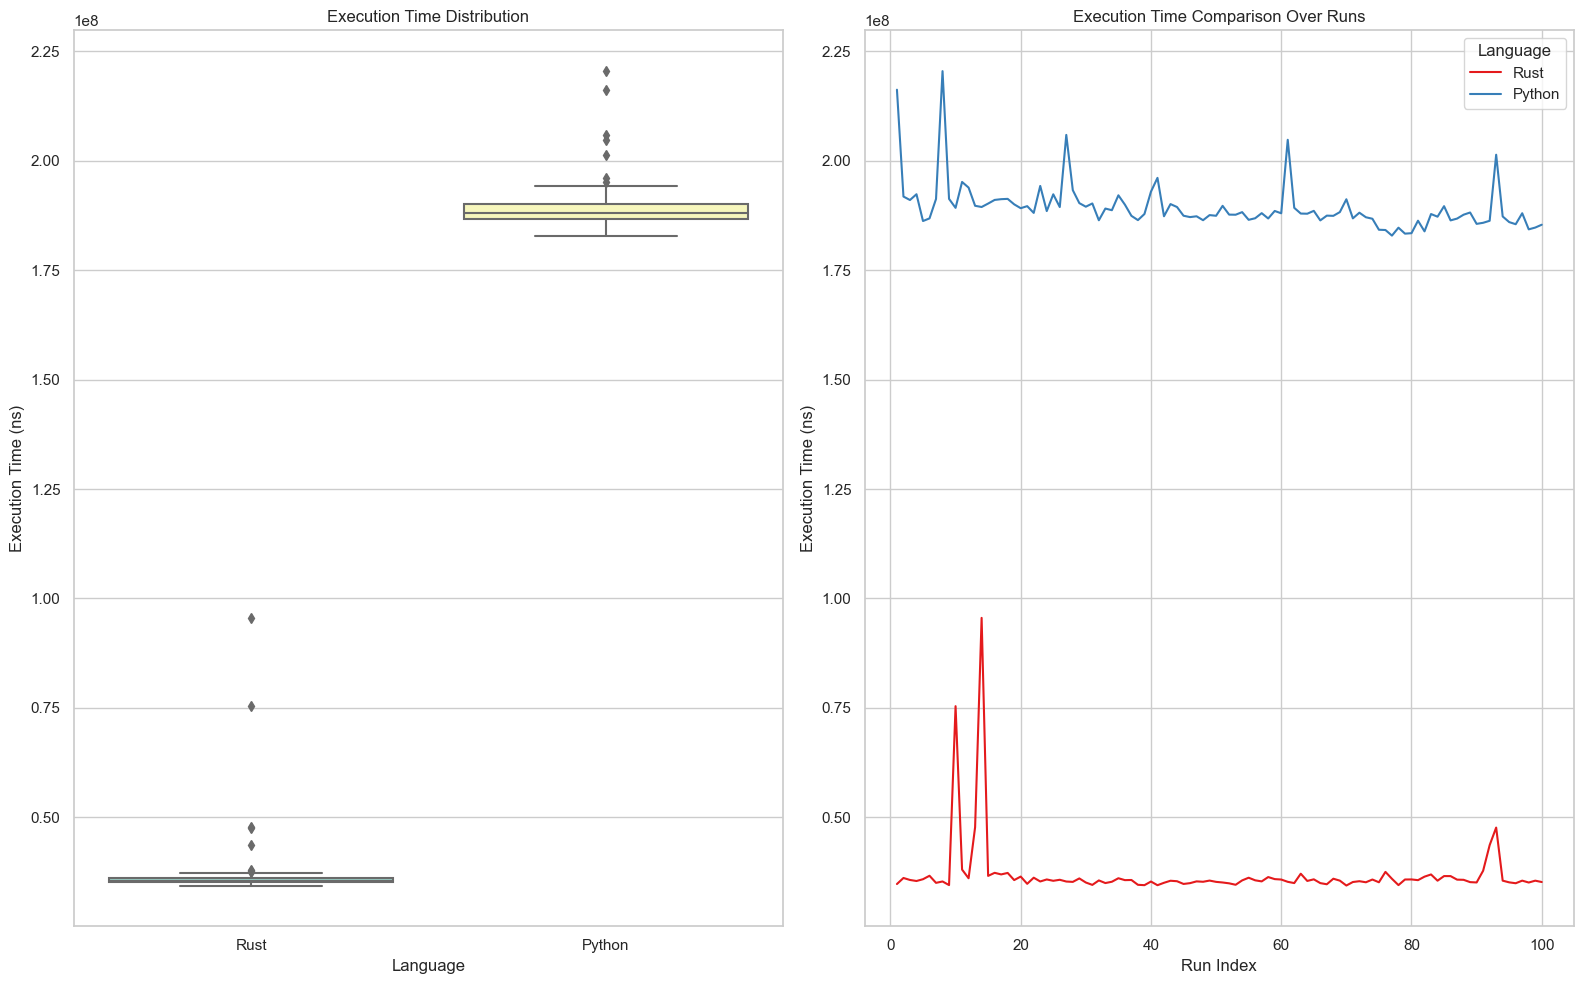

In [20]:
# EDA
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

rtimes = rtime
ptimes = ptime
# Create a DataFrame for easier plotting
data = pd.DataFrame({
    'Execution Time (ns)': np.concatenate([rtimes, ptimes]),
    'Language': ['Rust'] * len(rtimes) + ['Python'] * len(ptimes)
})

# Set the style
sns.set(style="whitegrid")

# Create the figure and axes
fig, axes = plt.subplots(1, 2, figsize=(16, 10))

# Box plot
sns.boxplot(x='Language', y='Execution Time (ns)', data=data, ax=axes[0], palette="Set3")
axes[0].set_title('Execution Time Distribution')
axes[0].set_xlabel('Language')
axes[0].set_ylabel('Execution Time (ns)')

# Line plot
sns.lineplot(data=pd.DataFrame({
    'Index': range(1, 101),
    'Rust': rtimes,
    'Python': ptimes
}).melt(id_vars=['Index'], var_name='Language', value_name='Execution Time (ns)'),
    x='Index', y='Execution Time (ns)', hue='Language', ax=axes[1], palette="Set1")

axes[1].set_title('Execution Time Comparison Over Runs')
axes[1].set_xlabel('Run Index')
axes[1].set_ylabel('Execution Time (ns)')

# Improve the layout
plt.tight_layout()

# Show the plot
plt.show()